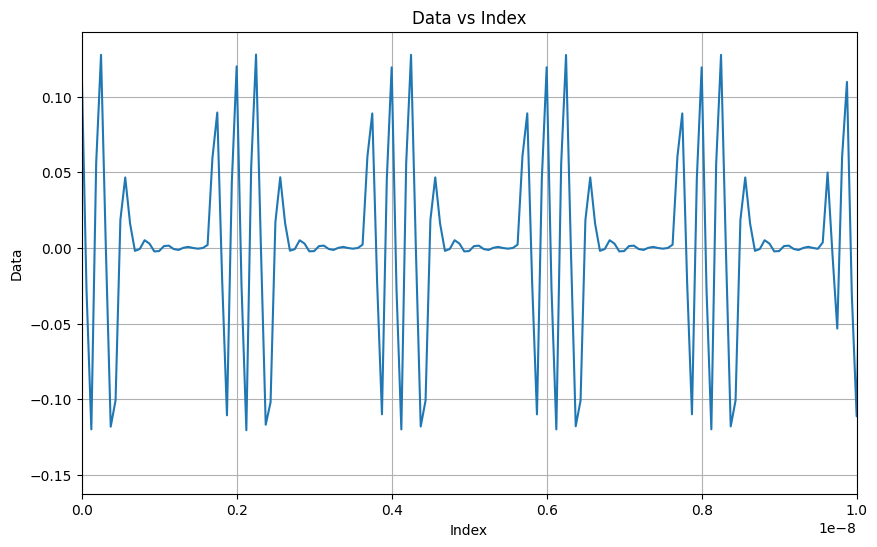

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV file from the csv folder in the current directory
csv_path = '../csv/data16.csv'
df = pd.read_csv(csv_path)

# 绘制Data列随Index的变化
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['data'])
plt.xlabel('Index')
plt.ylabel('Data')
plt.title('Data vs Index')
plt.grid(True)
plt.xlim(0, 1e-8)
plt.show()

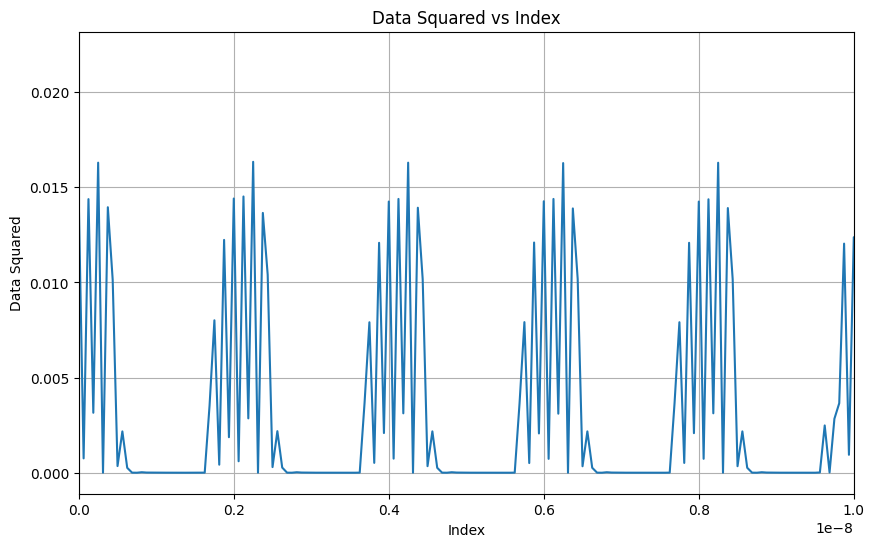

In [2]:
# Calculate the square of the data
df['Data_Squared'] = df['data'] ** 2
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Data_Squared'])
plt.xlabel('Index')
plt.ylabel('Data Squared')
plt.title('Data Squared vs Index')
plt.grid(True)
plt.xlim(0, 1e-8)
plt.show()

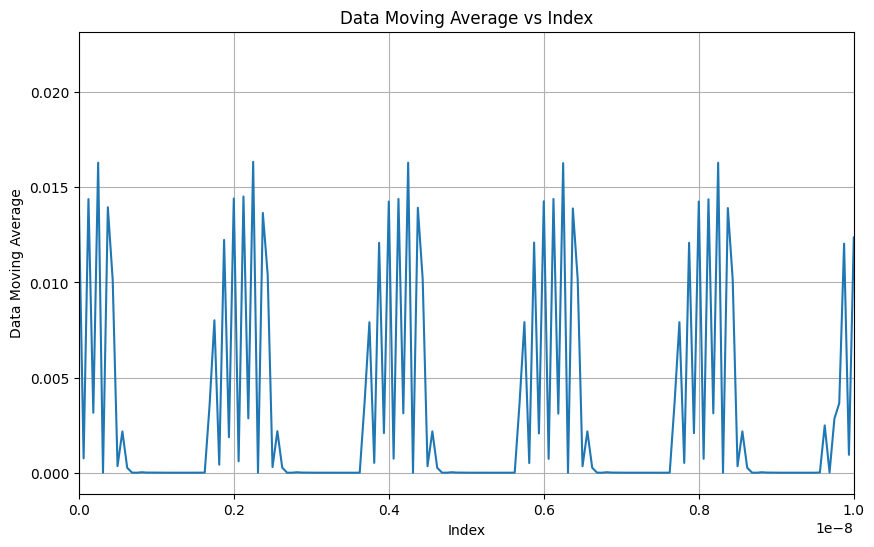

In [13]:
# apply a moving average with a window size of 32 * 0.5
# (32 = 16e9(sample rate) / 500e6 (symbol rate))
# df['Data_MA'] = df['Data_Squared'].rolling(window=int(4 * 0.5)).mean()
df['Data_MA'] = df['Data_Squared']
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Data_MA'])
plt.xlabel('Index')
plt.ylabel('Data Moving Average')
plt.title('Data Moving Average vs Index')
plt.grid(True)
plt.xlim(0, 1e-8)
plt.show()

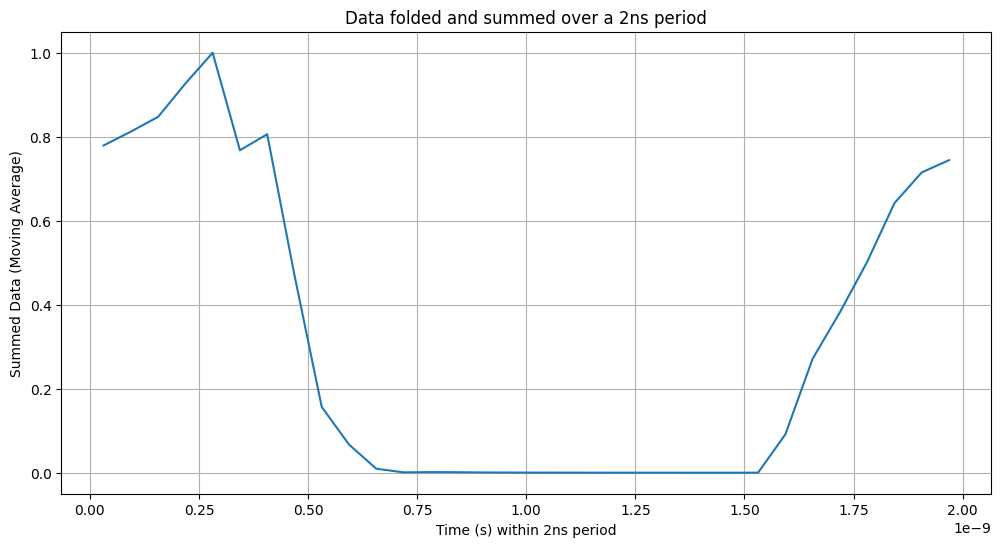

In [15]:
import numpy as np

# Define the period for folding
period = 2e-9  # 2 ns

# Use the moving average data, ensuring it's clean
if 'Data_MA' in df.columns:
    data_to_fold = df['Data_MA'].dropna()
    time_to_fold = df.loc[data_to_fold.index, 'time']

    # Calculate the time modulo the period
    folded_time = time_to_fold % period

    # To sum the data, we can create a new DataFrame and group by the folded time.
    # However, direct grouping on float values is problematic.
    # A better way is to bin the folded time and sum within bins.

    # Let's determine the time resolution from the original data
    time_resolution = time_to_fold.diff().mean()
    if pd.isna(time_resolution):
        # Fallback if diff().mean() results in NaN (e.g., only one point after dropna)
        time_resolution = (df['time'].iloc[1] - df['time'].iloc[0]) if len(df['time']) > 1 else 1e-12

    # Create bins for the 0-2ns range
    # Ensure num_bins is at least 1
    num_bins = max(1, int(period / time_resolution))
    bins = np.linspace(0, period, num_bins + 1)
    
    # Create a dataframe for folding
    fold_df = pd.DataFrame({'time': folded_time, 'data': data_to_fold})

    # Digitize the folded time to assign each time point to a bin
    # The labels are the indices of the bins.
    fold_df['time_bin'] = pd.cut(fold_df['time'], bins=bins, labels=False, include_lowest=True)

    # Group by the bins and sum the data
    summed_data = fold_df.groupby('time_bin')['data'].sum()

    # Create the time axis for the summed data (using the middle of each bin)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # The result of groupby might not have entries for all bins if some bins are empty.
    # Reindex the summed data to match the bins, filling missing bins with 0.
    summed_data = summed_data.reindex(range(len(bin_centers)), fill_value=0)

    # normalize the summed data to be between 0 and 1
    summed_data = (summed_data - summed_data.min()) / (summed_data.max() - summed_data.min())
    
    # Plot the result
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, summed_data)
    plt.xlabel('Time (s) within 2ns period')
    plt.ylabel('Summed Data (Moving Average)')
    plt.title('Data folded and summed over a 2ns period')
    plt.grid(True)
    plt.show()

else:
    print("Please run the moving average calculation cell first.")

The midpoint of the interval where data is > 0.2 is: 6.2500e-11 s
Need to delay the signal by 1.9375e-09 s (31 samples) to align with the midpoint.


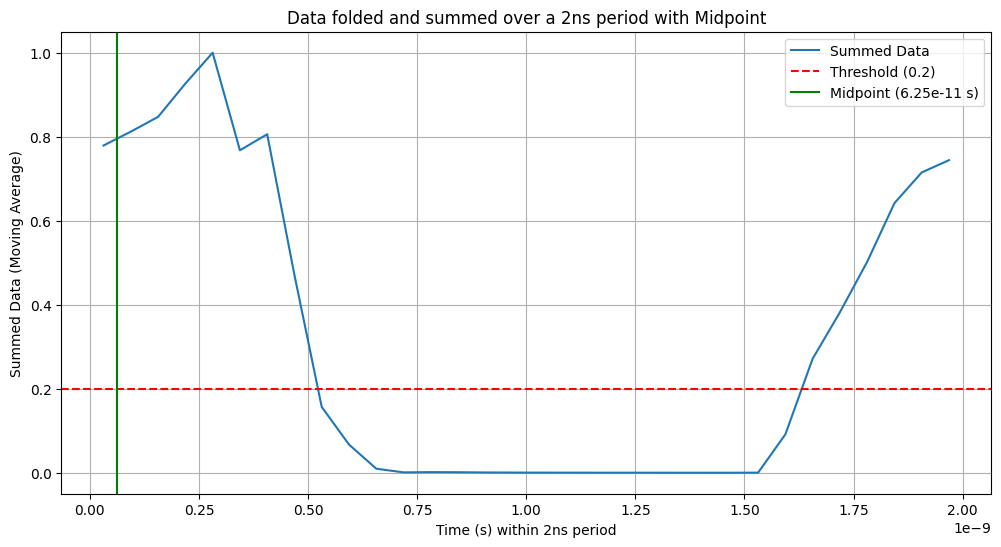

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'summed_data', 'bin_centers', and 'period' are available from the previous cell's execution context.
# If not, they would need to be redefined or recalculated here.
# For example: period = 2e-9

# Find where data is greater than 0.1
threshold = 0.2
# The 'summed_data' is a pandas Series, so we can use boolean indexing.
above_threshold = summed_data > threshold

if above_threshold.any():
    # Get the time values for these points
    time_above_threshold = bin_centers[above_threshold]

    # To handle the wrap-around case (as seen in the plot), we calculate the circular mean of the time points.
    # This is a robust way to find the center of points on a circle.
    
    # Convert time to angles (radians)
    angles = (time_above_threshold / period) * 2 * np.pi

    # Compute the mean of the sines and cosines of the angles
    mean_sin = np.mean(np.sin(angles))
    mean_cos = np.mean(np.cos(angles))

    # Calculate the mean angle from the mean sine and cosine
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Convert the mean angle back to time
    midpoint_time = (mean_angle / (2 * np.pi)) * period

    # The result of arctan2 is in [-pi, pi], which corresponds to [-period/2, period/2].
    # We adjust the midpoint to be in the [0, period] range.
    if midpoint_time < 0:
        midpoint_time += period

    print(f"The midpoint of the interval where data is > {threshold} is: {midpoint_time:.4e} s")
    print(f"Need to delay the signal by {2e-9 - midpoint_time:.4e} s ({int((2e-9 - midpoint_time) * 16e9)} samples) to align with the midpoint.")

    # For visualization, let's plot the original data and the calculated midpoint
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, summed_data, label='Summed Data')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.axvline(x=midpoint_time, color='g', linestyle='-', label=f'Midpoint ({midpoint_time:.2e} s)')
    plt.xlabel('Time (s) within 2ns period')
    plt.ylabel('Summed Data (Moving Average)')
    plt.title('Data folded and summed over a 2ns period with Midpoint')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print(f"No data points found above the threshold of {threshold}.")